[View in Colaboratory](https://colab.research.google.com/github/assaflehr/language-style-transfer/blob/master/notebooks/keras_nlp.ipynb)

In [74]:
!ps -ef | grep python

import tensorflow as tf
tf.test.gpu_device_name()


root        72    66  0 07:06 ?        00:00:03 /usr/bin/python2 /usr/local/bin/jupyter-notebook -y --no-browser --log-level=DEBUG --debug --NotebookApp.allow_origin="*" --NotebookApp.log_format="%(message)s" --NotebookApp.disable_check_xsrf=True --NotebookApp.token= --Session.key="" --Session.keyfile="" --ContentsManager.untitled_directory="Untitled Folder" --ContentsManager.untitled_file="Untitled File" --ContentsManager.untitled_notebook="Untitled Notebook" --KernelManager.autorestart=True --MultiKernelManager.default_kernel_name="python2" --ip="127.0.0.1" --port=9000 --port-retries=0 --notebook-dir="/content" --NotebookApp.base_url=/tun/m/m-2625u4lvj4ir5/
root        80    72 11 07:06 ?        00:04:54 /usr/bin/python3 -m ipykernel_launcher -f /content/.local/share/jupyter/runtime/kernel-5b160d10-d26d-4932-a448-a8ef81e381e2.json
root       283    80 99 07:50 pts/0    00:00:01 /bin/sh -c ps -ef | grep python
root       285   283  0 07:50 pts/0    00:00:00 grep python


''

>>[Keras accuracy/performace limitations](#scrollTo=Og2XNK-_53VP)

>[Performace caution :](#scrollTo=Og2XNK-_53VP)

>>[Pretraining autoencoder or LM will surely help.](#scrollTo=Og2XNK-_53VP)

>>>[LSTM](#scrollTo=Og2XNK-_53VP)

>>>[Tip to self:](#scrollTo=Og2XNK-_53VP)

>>>[For David: example of how to clone, then use from github](#scrollTo=OrKzdh71sBKm)

>[Some params](#scrollTo=MBAgWVvXycpF)

>[Dataset](#scrollTo=wwc6_EHFD_Ir)

>[Model defintion](#scrollTo=BWVEcaeF6DBR)

>[compile](#scrollTo=VTobPYftYvQC)

>[Sample and show sample](#scrollTo=xh5FwdLGU2n3)

>[TRAINING](#scrollTo=9s0-8EJi6AG1)

>[SAVE LOAD MODEL](#scrollTo=QOjAoPF-gAqx)

>[Error analysis](#scrollTo=XvIkFOWy55ov)

>>[Error of style disc.](#scrollTo=8QaOXXjUAwVH)

>[FAQ and wierd exceptions](#scrollTo=E2yLpQu4mvAS)



## Keras accuracy/performace limitations
 
# Performace caution :
G training epoc (250x64 rows) 

type|RNN|bidi?|time
--|--
CPU|LSTM|Y| 15 min|
GPU|LSTM|Y| 75s| (slower but more-accurate)
GPU|CuDNNLSTM|Y| 42s
GPU|CuDNNLSTM|N| 35s






## Pretraining autoencoder or LM will surely help.

see late review here: https://thegradient.pub/author/sebastian
and autoencoder (which is less recommended than LM here: "Semi-supervised Sequence Learning" 2015. They use one RNN for both encoder and decoder)


###   LSTM 
* CuDNNLSTM trains on GPU , but does not support the attributes: dropout,recurrent_dropout,which are the STOA regulaizers. This is cuda problem, and even native TF does not support it
Hard to compare only that. all G (with dense and more...) takes 35s on GPU. on CPU ???
* Make LSTM deep instead of bigger for linear instead of quadratic growth in compuation. when doing so, add skip connection to 2nd/3rd/... layers
* large vocab size means huge softmax, means slow runtime. to optimize training NCE loss replaces softmax on train-time (TF only)

### Tip to self:
* manually check loss value on one sample (predict vs gt). From doing this, I saw <s> was not given one-hot-value

### For David: example of how to clone, then use from github
```python
#!rm -r language-style-transfer  #remove previous github copy if needed
!git clone https://github.com/assaflehr/language-style-transfer.git
#we rename to as lang_transfer will be the package name
!mv language-style-transfer/code language-style-transfer/lang_transfer

# Add the local_modules directory to the set of paths Python uses to look for imports.
import sys
sys.path.append('language-style-transfer')

import lang_transfer   #your code here!!!
```

# util: SAVE LOAD MODEL

In [0]:
import os
import shutil
from time import gmtime, strftime



class GoogleDrive():
  
  def __init__(self):
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    self.drive = GoogleDrive(gauth)


  def save_to_drive(self,pathname):
    file_list = self.drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    data_from_colab=None
    for file1 in file_list:  
       if file1['title']=='data_from_colab':
          #print ('title: %s, id: %s' % (file1['title'], file1['id']))
          data_from_colab = file1['id']

    if (data_from_colab):
      f = self.drive.CreateFile({'parents':[{u'id': data_from_colab}]})
      f.SetContentFile(pathname)
      f.Upload() 
      f_id = f['id']
      print (f'saving {pathname} as id {f_id}')
      return f_id
    else:
      raise Exception('did not find')

      
  def load_from_drive(self,id_in_drive,local_pathname): #find it from share
    down= self.drive.CreateFile({'id': id_in_drive}) #{'id': '1nIcmbxc6c3Nic35O2JrSEmTmq7X6D2a2'}
    down.GetContentFile(local_pathname)   
  
  

class Persistency():
  
  def __init__(self):
    self.models_base_dir = 'models'
    if not os.path.exists(self.models_base_dir):
       os.makedirs(self.models_base_dir)
  
  def save_weights(self,models,model_names,save_to_gdrive=True):
    
    # keras can save model architecture + weights + opt_state using model.save
    # It can also sepately save weights and architecture as json
    # When using custom code (like our loss function), one need to use CustomObject (TODO)

    #we have 3 top-level-models
    # model = encoder_model + decoder_model
    # d = d_classfier_model + d_encoder_model
    # adv = encoder_model , classfier_model, decoder_model
    # but they share few of their weights
    time_str = strftime("%Y-%m-%d_%H-%M-%S", gmtime())

    
    models_time_dir = f'{models_base_dir}/{time_str}/'




    #TODO: split part of model, decoder_sampling_model to decoder weights only
    for i in range(len(models)):
      models[i].save_weights(models_time_dir +model_names[i]+'.h5')

    !ls -lh {models_base_dir}
    shutil.make_archive(f'{models_base_dir}/models_weights_{time_str}','zip', models_time_dir) 
    !ls -lh {models_base_dir}

    if (save_to_gdrive):
      drive = GoogleDrive()
      drive.save_to_drive(f'{models_base_dir}/models_weights_{time_str}.zip')


  def load_weights_from(self,models,model_names,folder,download_gdrive_id=None) :
    """ id_in_drive - default None. If not, download from google-drive (id is the shared-link id)"""
    time_str = strftime("%Y-%m-%d_%H-%M-%S", gmtime())
    if download_gdrive_id:
      self.drive = GoogleDrive()
      uploaded_zip = f'{self.models_base_dir}/models_weights_{time_str}_OUT.zip'
      self.drive.load_from_drive(download_gdrive_id,uploaded_zip)
      #extract_dir=f'{models_base_dir}/{time_str}/')
      shutil.unpack_archive(uploaded_zip, folder)
      print ('loaded into ',folder)
      
    for i in range(len(models)):
      pathname = f'{folder}/{model_names[i]}.h5'
      if not os.path.exists(pathname):
        print (pathname,'missing. breaking!')
        return
      else:
        print ('loading',pathname)
      models[i].load_weights(pathname)
    print ('load from ',folder,'complete. Make sure you already compiled the model and set optimizers')

    
#models      = [encoder_model   , model,    decoder_sampling_model,   d_classifier_model] #rest can be built from them?  
#model_names = ['encoder_model', 'model', 'decoder_sampling_model','d_classifier_model' ] #rest can be built from them?  
#Persistency().load_weights_from('models/2018-07-15_10-15-21',models,model_names)
def test_drive():
  GoogleDrive()
  i=save_to_drive('language-style-transfer/LICENSE')
  load_from_drive(i,'language-style-transfer/LICENSE_OUT_2')
  !ls -l language-style-transfer
    
#models      = [encoder_model   , model,    decoder_sampling_model,   d_classifier_model] #rest can be built from them?  
#model_names = ['encoder_model', 'model', 'decoder_sampling_model','d_classifier_model' ] #rest can be built from them?  
#Persistency().load_weights_from(models,model_names,download_gdrive_id='12Ib2nxiT5H7QbOmsM2-rTRGj4_Pxnxt0',folder='from_upload')


In [0]:
# adaptation of: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# first Dataset class to load bible-data
# then copy of the model, but working with words instead of chars





# Some params

In [0]:
embedding_dim=300 #100-300 good numbers

# for hidden unit of LSTM. Increasing it increase the model strength (and compuation time).
# increasing should increase fit to train (and when using stronger reguralization/dropout even val)
latent_dim = 256

bidi_encoder=False

cuddlstm=True  
 
# LSTM dropouts, one of the best ways to fight overfiltting. ragnge 0-0.5++ (0 means no dropout)
# Increase it to reduce diff between train and val
en_lstm_dropout=0.3          
en_lstm_recurent_dropout=0.3 #only relevant if NOT cuddlstm.
de_lstm_dropout=0.0          #only relevant if NOT cuddlstm.
de_lstm_recurent_dropout=0.0 #only relevant if NOT cuddlstm

batch_size=64

#how much weight to assign to adv-classifier compared to 1.0 of reconstruction-loss
# 1.0 - 100.0 means same. 10.0 means ten time more, etc
adv_loss_weight= 50.0 



Questions on dataset class: 

Does the vocabulary persisted? if not, is it verified that tokens keep thier index, even in cases of two token with the same frequency?

# Dataset

In [66]:
import codecs
import csv
import random
import re
from collections import Counter
import numpy as np
from keras.utils.data_utils import get_file

END_SYMBOL = '<end>'
START_SYMBOL = '<start>'
SPEC_CHARS_REPLACEMENT = {'.': ' <DOT> ', ',': ' <COMMA> ', ';': ' <SEMICOLON> ', ':': ' <COLON> ', '!': ' <EXCL> ',
                          '?': ' <QSTN> ', "'": ' <QUOTE> '}
SPEC_CHARS_RECONSTRUCT = {' ' + v.strip(): k for (k, v) in SPEC_CHARS_REPLACEMENT.items()}

MIN_FREQ = 15
URL_ROOT = "https://raw.githubusercontent.com/scrollmapper/bible_databases/master/csv/t_"
CSV_EXT = ".csv"
OOV = '<OOV>'
MAX_SENTENCE_LENGTH = 20 #60


def multi_replace(string, replacements, ignore_case=False):
    """
    Given a string and a dict, replaces occurrences of the dict keys found in the
    string, with their corresponding values. The replacements will occur in "one pass",
    i.e. there should be no clashes.
    :param str string: string to perform replacements on
    :param dict replacements: replacement dictionary {str_to_find: str_to_replace_with}
    :param bool ignore_case: whether to ignore case when looking for matches
    :rtype: str the replaced string
    """
    rep_sorted = sorted(replacements, key=lambda s: len(s[0]), reverse=True)
    rep_escaped = [re.escape(replacement) for replacement in rep_sorted]
    pattern = re.compile("|".join(rep_escaped), re.I if ignore_case else 0)
    return pattern.sub(lambda match: replacements[match.group(0)], string)


class Dataset:
    def __init__(self):
        self.word2index = {}
        self.index2word = {}
        self.frequencies = {}

    def create_mapping(self, corpora):
        segs = [seg for corpus in corpora.values() for sentence in corpus for seg in sentence]
        frequencies = Counter(segs).items()
        oov = [c for (_, c) in frequencies if c <= MIN_FREQ]
        self.frequencies = {k: l for (k, l) in frequencies if l > MIN_FREQ or k == OOV}
        self.frequencies[OOV] = sum(oov)
        self.word2index = {seg: num for (num, seg) in enumerate(self.frequencies.keys())}
        
        markers = [START_SYMBOL, END_SYMBOL] + list(corpora.keys())
        for m in markers:
            self.word2index[m] = len(self.word2index)
        self.index2word = {v: k for k, v in self.word2index.items()}

    def tokenize(self, corpora):
        self.create_mapping(corpora)
        oov = self.word2index[OOV]
        return {key: [[self.word2index.get(seg, oov) for seg in sentence] for sentence in corpus]
                for (key, corpus) in corpora.items()}

    @staticmethod
    def normalize(sentence):
        sentence = re.sub('[^ a-zA-Z0-9.,:;!\?{}]', ' ', sentence.lower())
        return multi_replace(sentence, SPEC_CHARS_REPLACEMENT)


class BibleDataset(Dataset):
    def __init__(self, base_url, files, suffix, test_split=0.1, validation_split=0.1):
        super().__init__()
        corpora, index = BibleDataset.parse_csv(base_url, files, suffix)
        self.corpora = self.tokenize(corpora)
        self.train, self.val, self.test = self.split(index, test_split, validation_split)
        sentence_lengths = [len(s) for c in self.corpora.values() for s in c]
        self.max_sentence_length = max(sentence_lengths)
        self.style2index = {s: i for (i, s) in enumerate(corpora.keys())}
        self.index2style = {v:k for k, v in self.style2index.items()}

    @staticmethod
    def parse_csv(base_url, files, suffix):
        corpora = {}
        for file in files:
            corpus = {}
            with open(get_file(file, base_url + file + suffix, cache_dir='/tmp/bible.cache/'), "rb") as webfile:
                for idx, row in enumerate(csv.reader(codecs.iterdecode(webfile, 'utf-8'))):
                    if idx > 0:
                        segs = BibleDataset.normalize(row[4]).split()
                        if len(segs) > MAX_SENTENCE_LENGTH:
                            segs = segs[:MAX_SENTENCE_LENGTH]
                        corpus[tuple(int(v) for v in row[:-1])] = segs
            corpora['<{}>'.format(file)] = corpus

        keysets = [set(ks.keys()) for ks in corpora.values()]
        intersection = sorted(list(keysets[0].intersection(*keysets[1:])))

        corpora = {file: [corpus[key] for key in intersection] for (file, corpus) in corpora.items()}
        index = [key[1] for key in intersection]

        return corpora, index

    @staticmethod
    def split(index, test_split, validation_split):
        count_test = len(index) * test_split
        count_validation = len(index) * validation_split
        count = Counter(index)

        sum_validation = 0
        sum_test = 0

        test = []
        validation = []

        for i in reversed(range(1, len(count) + 1)):
            if sum_test < count_test:
                sum_test += count[i]
                test += [i]
            elif sum_validation < count_validation:
                sum_validation += count[i]
                validation += [i]
            else:
                break
        test = set(test)
        validation = set(validation)
        train = set(index) - test - validation

        train = (0, sum([count[i] for i in train]) - 1)
        validation = (train[1] + 1, train[1] + sum([count[i] for i in validation]))
        test = (validation[1] + 1, validation[1] + sum([count[i] for i in test]))

        return train, test, validation

    def pad_sentence(self, sentence, length):
        return sentence + [self.word2index['<end>']] * (length - len(sentence))

    def recostruct_sentence(self, sentence):
        return multi_replace(' '.join([self.index2word[seg] for seg in sentence]),
                                   SPEC_CHARS_RECONSTRUCT)

    def sample_batch(self, data_range, batch_size):
        style_names = list(self.corpora.keys())
        styles = random.choices(range(len(self.corpora)), k=batch_size)
        sample = zip(styles, random.sample(range(*data_range), batch_size))
        return [self.pad_sentence(self.corpora[style_names[corp]][sent], self.max_sentence_length)
                for corp, sent in sample], styles

    def enc_input(self, batch):
        return np.array([s + [self.word2index['<end>']] for s in batch], int)

    def dec_input(self, batch, styles):
        return np.array([[self.word2index[style]] + s for (s, style) in zip(batch, styles)], int)

    def gen_g(self, data_range, batch_size=64):
        while True:
            batch, styles = self.sample_batch(data_range, batch_size)
            dec_input = self.dec_input(batch, [self.index2style[style] for style in styles])

            yield [self.enc_input(batch), dec_input], keras.utils.to_categorical(dec_input,
                                                                                 len(self.word2index)).astype(
                int)

    def gen_d(self, data_range, batch_size=64):
        while True:
            batch, styles = self.sample_batch(data_range, batch_size=batch_size)
            yield self.enc_input(batch), keras.utils.to_categorical(styles, len(self.corpora)).astype(int)

    def gen_adv(self, data_range, batch_size=64):
        while True:
            batch, styles = self.sample_batch(data_range, batch_size=batch_size)
            dec_input = self.dec_input(batch, [self.index2style[style] for style in styles])
            yield [self.enc_input(batch), dec_input], \
                  [keras.utils.to_categorical(dec_input, len(self.word2index)).astype(int),
                   keras.utils.to_categorical(styles, len(self.corpora)).astype(int)]


    @staticmethod
    def normalize(sentence):
        sentence = Dataset.normalize(sentence)

        psalms = re.findall('psalm [0-9]+', sentence)

        if len(psalms) > 0:
            sentence = sentence.split(psalms[0])[0]

        sentence = re.sub(r'\{(.*?)\}', '', sentence)
        sentence = re.sub('[0-9]+ <COLON> [0-9]+', '', sentence)

        return sentence


def test_bible_dataset():
    #x,y = next(dataset.gen_d(dataset.train, 4))
    #print (x.shape,y.shape,y[0])
    print ('vocab',len(dataset.word2index))

#dataset = BibleDataset(URL_ROOT, ["asv", "bbe", "dby", "kjv", "wbt", "web", "ylt"], CSV_EXT)
# differences: very old , formal: ylt . very dynamic, simple words: bbe, middle ground (5 similiar wbt)

dataset = BibleDataset(URL_ROOT, ["bbe", "ylt"], CSV_EXT) 

test_bible_dataset()  



vocab 2911


In [67]:
print(len(dataset.word2index))
print(len(dataset.index2word))



2911
2911


In [0]:
import keras
from keras.callbacks import ReduceLROnPlateau
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
      self.losses = {'loss':[],'val_loss':[]}
      
    #def on_train_begin(self, logs={}):
    #  pass  
    
    def on_epoch_end(self, batch, logs={}):
      for loss in ['loss','val_loss']:
        self.losses[loss].append(logs.get(loss))
        
np.random.seed(42)


def gen(t,batch_size,gen_type):
    """grn_type = g/d/adv
    usage: gen(dataset.result.train,batch_size,'g')
    """
    x_encoder,x_decoder,y_one_hot_decoder,y_style = t
    WORDS=x_encoder.shape[1]
    while 1:
      ind=np.array(np.random.randint(len(x_encoder),size=(batch_size) ))
      
      #build decoder target data on the fly
      one_hot = np.zeros((batch_size,WORDS,len(dataset.index2word)))
      for row in range(batch_size):
         for t in range(WORDS):
            one_hot[row,t,int(x_encoder[ind][row,t])] = 1
      
      if gen_type=='g':
        yield ([x_encoder[ind],x_decoder[ind]],one_hot)
      elif gen_type=='d':
        yield (x_encoder[ind],y_style[ind])
      elif gen_type=='adv':
        yield ([x_encoder[ind],x_decoder[ind]],[one_hot,y_style[ind]]) #y_one_hot_decoder[ind]
      else:
        raise ValueError('gen_type unkown',gen_type)



import matplotlib.pyplot as plt 

# summarize history for loss
def plt_losses(loss_history,title,with_val=False):
  plt.plot(loss_history.losses['loss'][:])
  if with_val:
    plt.plot(loss_history.losses['val_loss'][:])
  plt.title(title)
  med=0.1 if len(loss_history.losses['loss'])<1 else np.median(loss_history.losses['loss'])
  plt.ylim(ymin=-0.1)
  plt.ylim(ymax=med+1.5)
  plt.ylabel('loss')
  plt.xlabel('batchse')
  plt.legend(['train', 'val'], loc='upper right')
  

def plt_all():  
  plt.figure(figsize=(14,4))
  plt.subplot(131) #numrows, numcols, fignum
  plt_losses(loss_history,'g loss')  
  plt.subplot(132)
  plt_losses(loss_history_d,'d loss')  
  plt.subplot(133)
  plt_losses(loss_history_adv,'adv loss') 
  plt.show()


  
loss_history = LossHistory()
loss_history_d = LossHistory()
loss_history_adv = LossHistory()  


def train_g(g, steps, validation_steps=1):
    model.fit_generator(dataset.gen_g(dataset.train, batch_size),
                        steps,
                        validation_steps=validation_steps,
                        validation_data=dataset.gen_g(dataset.val, batch_size),
                        callbacks=[loss_history],
                        verbose=0 if steps < 10 else 1,
                        # max_queue_size=10,
                        # workers=2
                        )

    # model.fit([x_train, x_train_d], y_train,


def train_d(d, steps, validation_steps=1):
    # %time d_encoder_model.set_weights(encoder_model.get_weights())
    d.fit_generator(dataset.gen_d(dataset.train, batch_size),
                    steps,
                    validation_steps=validation_steps,
                    validation_data=dataset.gen_d(dataset.val, batch_size),
                    verbose=0 if steps < 20 else 1,
                    callbacks=[loss_history_d])
    # d.fit(x_train, style_train,


def train_adv(adv_model, steps, validation_steps=1):
    # %time classifier_model.set_weights(d_classifier_model.get_weights())

    adv_model.fit_generator(dataset.gen_adv(dataset.train, batch_size),
                            steps,
                            validation_steps=validation_steps,
                            validation_data=dataset.gen_adv(dataset.val, batch_size),
                            verbose=0 if steps < 10 else 1,
                            callbacks=[loss_history_adv])
 
  


In [69]:
next(dataset.gen_adv(dataset.train, 20))

([array([[ 285,   44,    1,  110,   18, 1039,   22,  188, 1042,  206,  140,
           270,   53,  114,   13,  142,    1,  344,  110,  179, 2908],
         [ 229,  119,   82,  327,  158,   29,   48,  177,  226,  887,  206,
           309, 2906,   22,    6,  175, 1199,   22,  242,    1, 2908],
         [   1,  128,  712,   44,    1,  128,  374,    9, 2906,    1, 2906,
            22,   18,    1,  314,   18,  998,   13,    6,   53, 2908],
         [ 993,  888,   31,  990,  110,  809,  202,  322, 1286,   53,   31,
           453,    8, 2908, 2908, 2908, 2908, 2908, 2908, 2908, 2908],
         [   6,  115, 2359,    1, 1088,   53,    1,  518,   18, 1961,   94,
          2906,   22,   94, 2906,   22,    6,   94, 2906,   22, 2908],
         [ 142,  207,   22,   16,   95,  766,  569,   16,   95, 2906,   22,
           162,  115,  206,  140,  793,   22,   24,  158,   31, 2908],
         [   6, 1871,  143,  145,    1, 1574,    6,  181,  151,  101,  225,
            46, 1341,   24,   22, 2906,   

# Model defintion



(1) We start with regular seq2seq is encoder->embedding->decoder and trained with reconstruction-loss

(2)We can build style-discriminator where the target is to classify author-style from the sentence-embedding.
When training it you need to freeze the encoder and decoder parts of the model, then:
input1: sentence --freezed encoder--> embedding    (no need to run decoder)
input2: style (one-hot)
output: style (one-hot)  
The discriminator can be a simple classifier (dense-based) with simple minimize cross-entropy target.

(3) The smart-part: We want to train the encoder to create an embedding which will fool the discriminator.
We will freeze the discriminator weights, and train the encoder-decoder similiarly to (1) with extra objective.
That the loss from the discriminator will be Maximized. 




In [70]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding,CuDNNLSTM,Bidirectional,Concatenate,Dropout

# size of tokenizer indexes

num_decoder_tokens = num_encoder_tokens = len(dataset.word2index) 
print (num_decoder_tokens)
decoder_latent_dim = latent_dim*2 if bidi_encoder else latent_dim
shared_embedding = Embedding(num_encoder_tokens, 
                       embedding_dim, 
                       #weights=[word_embedding_matrix], if there is one (word2vec)
                       #trainable=False,                            
                       #input_length=MAX_SEQUENCE_LENGTH, if there is one
                       )

# Define an input sequence and process it.  
# input: batch,num-of-words of integers (not-one-hot)
# each batch should be of the size and padded, but between batches size can be different
# batch 1:   len 7,8,9,10(max)  inside the same batch, size is similiar (less waste on GPU)
# batch 2 :    len 97-100(max)  between batches size is different.
# order is random... sometime small batch sometime large 

  

def build_encoder_model(encoder_inputs):
  
  #Dropout(noise_shape=(batch_size, 1, features))
  x = shared_embedding(encoder_inputs) 
  if (cuddlstm):
    encoder_lstm=CuDNNLSTM(latent_dim, return_state=True)
  else:
    print ('using LSTM with dropout!')
    #need to tune the dropout values (maybe fast.ai tips) , just invented those value
    #see dropout disucssion: https://github.com/keras-team/keras/issues/7290. iliaschalkidis 
    encoder_lstm=LSTM(latent_dim, return_state=True,dropout=en_lstm_dropout,recurrent_dropout=en_lstm_recurent_dropout,name='rnn_encoder')
  if (bidi_encoder):
    encoder_lstm=Bidirectional(encoder_lstm,merge_mode='concat',name='rnn_encoder')
    x, forward_h, forward_c, backward_h, backward_c = encoder_lstm(x) #output,h1,c1,h2,c2
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
  else:  
    x, state_h, state_c = encoder_lstm(x)

  encoder_states = [state_h, state_c]  #sentence embedding LSTM: h,c  
  encoder_model = Model(encoder_inputs, encoder_states)
  return encoder_model



def build_decoder_model(encoder_model,encoder_inputs,decoder_inputs):  
  # Set up the decoder, using `encoder_states` as initial state.
  #looks similiar to  
  #gold decoder_ouputs: [1,0,0] [0,1,0] one-hot of the below
  #encoder_inputs:      hello   world <end> <end>
  #decoder_input      : <style> hello world <end>   | style = bible1,bible2,(maybe-generic for pertraining)
  #encoder_inputs = Input(shape=(None,),name='encoder_inputs') 
  #decoder_inputs = Input(shape=(None,),name='decoder_inputs')  

   #bi-di pass merge of h1+h2, c1+c2
  if (cuddlstm):
    decoder_lstm = CuDNNLSTM(decoder_latent_dim, return_sequences=True,return_state=True,name='rnn_decoder') #returned state used in inference
  else:
    decoder_lstm = LSTM(decoder_latent_dim, return_sequences=True,return_state=True,
                        dropout=de_lstm_dropout,recurrent_dropout=de_lstm_recurent_dropout,name='rnn_decoder')
  #decoder_outputs, _, _  = decoder_lstm(shared_embedding(decoder_inputs), initial_state=encoder_states)
  decoder_outputs, _, _  = decoder_lstm(shared_embedding(decoder_inputs), initial_state=encoder_model(encoder_inputs))
  decoder_dense  = Dense(num_decoder_tokens, activation='softmax',name='decoder_softmax')
  decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  decoder_teacher_forcing_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  

  ##################################################################
  ################# decoder-sampling model #########################
  ##################################################################
  # now for the SAMPLING models (re-arrangement of the prev one)
  # Remember that the training model varaibles were:
  #                                        decoder_outputs
  #encoder   --->    encoder_states  -->   decoder_lstm  
  #shared_embedding                        shared_embeddings  
  #encoder_inputs                          decdoer_inputs 
  #decoder_latent_dim = latent_dim*2 if bidi_encoder else latent_dim #bi-di pass merge of h1+h2, c1+c2
  decoder_states_inputs = [Input(shape=(decoder_latent_dim,)), Input(shape=(decoder_latent_dim,))]

  #decoder_outputs2, state_h, state_c = decoder_lstm(shared_embedding(decoder_inputs), initial_state=decoder_states_inputs)
  decoder_outputs2, state_h, state_c = decoder_lstm(shared_embedding(decoder_inputs), initial_state=decoder_states_inputs)

  decoder_states = [state_h, state_c]
  decoder_outputs2 = decoder_dense(decoder_outputs2)

  decoder_sampling_model = Model(
      [decoder_inputs] + decoder_states_inputs,
      [decoder_outputs2] + decoder_states)

  return decoder_teacher_forcing_model,decoder_sampling_model




##################################################################
############################# d model ############################
##################################################################

def build_d():#encoder_model,d__encoder_inputs):
  # IN on the sentnece embedding itself )list of h,c]
  # Out style embedding
  #d__states = encoder_model(d__encoder_inputs)
  
  d__states = [Input(shape=(decoder_latent_dim,)), Input(shape=(decoder_latent_dim,))]
  d__a = Concatenate(name='d__concat1')(d__states)
  d__a = Dropout(0.1,name='d__dropout1')(d__a)                          
  # if your inputs have shape  (batch_size, timesteps, features) and you want the dropout mask to be the same for all timesteps, you can use noise_shape=(batch_size, 1, features).
  d__a=Dense(100,activation='relu',name='d__dense1')(d__a) #a = keras.layers.LeakyReLU()(a) #LeakyReLU  #why leaky? see: how to train your GAN - BUT IT FAILED TO LEARN (accuracy always 0.5)
  d__a = Dropout(0.1,name='d__dropout2')(d__a)
  d__style_outputs = Dense(len(dataset.style2index),activation='softmax',name='d__dense_softmax')(d__a)

  #d = Model(d_inputs,style_outputs)
  #d = Model(d__encoder_inputs,d__style_outputs)  #style_outputs : batch , one-hot-encoding-of-style
  d = Model(d__states,d__style_outputs,name='style_classifier')  #style_outputs : batch , one-hot-encoding-of-style
  return d



##################################################################
############################# Adv model ##########################
##################################################################

from keras import backend as K

# Note that it does not have new layers, just combining all of them with new loss
def inverse_categorical_crossentropy(y_true, y_pred):
  #need to implement it better , sum(1/categorical_crossentropy_per_sample)
  # if discriminator is random, on 2 styles, if expect 50% which should mean logloss of 1. so 1/1= 1
  # if discriminator is great, 99%, log-loss close to 0 , so 1/0 is big.
  # so expeceted range is GREAT=1 , BAD=BIGGG
  return 1/(K.categorical_crossentropy(y_true, y_pred)+0.0001)

 
# Careful note:  we have one shared encoder model here, but two unshared classifiers
# the weights in the classifier-head in 'd' are seperate between d, and g_d(adv)
encoder_inputs = Input(shape=(None,),name='encoder_inputs')
decoder_inputs = Input(shape=(None,),name='decoder_inputs')  
encoder_model = build_encoder_model(encoder_inputs)  
model,decoder_sampling_model = build_decoder_model(encoder_model,encoder_inputs,decoder_inputs)
# TODO: improve optimizer = ''#clipvalue=0.5,clipnorm=1.0) 
model.compile(optimizer='adam', loss='categorical_crossentropy')  #30peocs loss: 0.2836 - val_loss: 0.4428


# Seperate everything in d , both Encoder and Classfier
d_encoder_model = build_encoder_model(encoder_inputs)  
d_encoder_model.trainable=False
d_classifier_model = build_d()
d = Model(encoder_inputs,d_classifier_model(d_encoder_model(encoder_inputs)))
d.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
#train_d(d,50) # TRAINING WELL alone , had used wrong names for models

classifier_model = build_d()
adv_d_out = classifier_model(encoder_model(encoder_inputs))# encoder_model,encoder_inputs)
adv_model = Model([encoder_inputs,decoder_inputs],[model.output,adv_d_out])
# in adv , encoder is not trainable. decoder is not.
classifier_model.trainable=False
#print_trainable(adv_model)      
adv_model.compile(optimizer='adam', 
                  loss=['categorical_crossentropy',inverse_categorical_crossentropy],
                  loss_weights=[1, adv_loss_weight])


#train_g(model,10) # TRAINING WELL! 
#train_d(d,50)



2911


# Sample and show sample

In [71]:
max_decoder_seq_length= dataset.max_sentence_length+1 #always pad one

# TODO: now it's greedy and use argmax
# maybe to choose randomly by distribution
# and maybe to implement BEAM SEARCH
def decode_sequence(input_seq,style,verbose=False):
    assert input_seq.shape == (1, max_decoder_seq_length )
    if verbose: print ('input_seq',input_seq.shape)
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    if verbose: print ('encoder result states_value','h',states_value[0].shape,states_value[0].mean(),'c',states_value[1].shape,states_value[1].mean())
    
    # Generate empty target sequence of length 1.
    #                      batch,word-number value is token (0 /122)
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = dataset.word2index[style]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        #start with encoder-state then change to self state
        output_tokens, h, c = decoder_sampling_model.predict( [target_seq] + states_value) 
        if verbose: print ('output_tokens',output_tokens.shape,output_tokens.mean(),'h',h.shape,'c',c.shape)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens)# [0, -1, :])
        if verbose: print ('sampled_token_index',sampled_token_index.shape,output_tokens.max(),sampled_token_index)
        decoded_sentence.append(sampled_token_index)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_token_index == dataset.word2index[END_SYMBOL] or
           len(decoded_sentence) > max_decoder_seq_length):
          stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    res= np.array(decoded_sentence) #[dataset.index2word[index] for index in decoded_sentence]
    return res

  

def show_sample(data_type='val',teacher_forcing=False,sample_id=[],replace_style=['t_bbe.csv','t_ylt.csv'],show_other_style=True):
  """ 
    data_type - train/val/test
    teacher_forcing : default False, sample argmax as for normal test. If true, feed decode-input from the dataset itself
    sample_id : verse-id to sample (list)
    replace_style: if true, will pass a different style
  """
  styles = ['<bbe>','<ylt>']
  #corp1 = dataset.corpora['<bbe>']
  #corp2 = dataset.corpora['<ylt>']
  #data1={'train': corp1[dataset.train[0]:dataset.train[1]], 'val':corp1[dataset.val[0]:dataset.val[1]] , 'test':corp1[dataset.test[0]:dataset.test[1]]}
  #data2={'train': corp2[dataset.train[0]:dataset.train[1]], 'val':corp2[dataset.val[0]:dataset.val[1]] , 'test':corp2[dataset.test[0]:dataset.test[1]]}
  
  for i in sample_id:
    print ('#'*30,'verb',i,'#'*30)
    
    if data_type=='train':
      r = dataset.train
    elif data_type=='val':
      r = dataset.val
    else:
      r = dataset.test
    
    start,end = r[0],r[1] 
    
    for style in styles:
      sentence = dataset.corpora[style][start:end][i]
      print (f'\n##encoder_input[{style}]:',dataset.recostruct_sentence(sentence) )
      
      # decode it in every possible style, by replacing style
      one_x   = dataset.enc_input([dataset.pad_sentence(sentence,dataset.max_sentence_length)]).reshape(1,-1)
      one_x_d = dataset.dec_input([dataset.pad_sentence(sentence,dataset.max_sentence_length)], [style]).reshape(1,-1)
      
      for replaced_style in styles:
        # always replace_style:
        one_x_d= np.copy(one_x_d)
        one_x_d[0,0]=dataset.word2index[replaced_style]

        if teacher_forcing:
          p = model.predict([one_x,one_x_d])
          p = p[0].argmax(axis=1)
          print (f'decoder TF     [{replaced_style}]:',dataset.recostruct_sentence(p))
        else:
          p = decode_sequence(one_x,replaced_style)
          
          print (f'decoder sample [{replaced_style}]:',dataset.recostruct_sentence(p))
        
        gold_label = dataset.corpora[replaced_style][start:end][i]
        print (f'gold label     [{replaced_style}]:',dataset.recostruct_sentence(gold_label))
          
          
# please see more in error-anlysis section
show_sample('train',sample_id=[0],teacher_forcing=True) 
show_sample('train',sample_id=[0],teacher_forcing=False) 


############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth.


InvalidArgumentError: ignored

# TRAINING

In [0]:
#train_g(model,100,validation_steps=100) 
#train_d(d,10,validation_steps=100) 
#train_adv(adv_model,100,validation_steps=100) 


In [73]:
train_size = len(dataset.index2style) * (dataset.train[1] - dataset.train[0])
epoc = int(train_size/batch_size)
print ('epoc is of',epoc,'of batches',batch_size,'total train_size',train_size)


######## PRE TRAINING ##########################
for i in range(10):
  print ('epoc',i)
  show_sample('train',sample_id=[0],teacher_forcing=True) 
  train_g(model,epoc*1,validation_steps=100)  #pretrain
  
  
  l=loss_history.losses['loss'][-1:][0]
  if l<0.5: #0.5 is good value for 20 length sentences. for longer, NOT!
    print ('early break at break at',l,'epoc',i)
    break
  

for i in range(10):
  train_d(d,epoc,validation_steps=100)
  l=loss_history_d.losses['loss'][-1:][0]
  if l<2:
    print ('early break at break at',l,'epoc',i)
    break

# Expect to see nice results on G with 10 words , when loss is <2. If not continue training a bit

epoc is of 755 of batches 64 total train_size 48354
epoc 0
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth.


InvalidArgumentError: ignored

epoc contains  750 batches of 64
############################## epocs 0
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to w

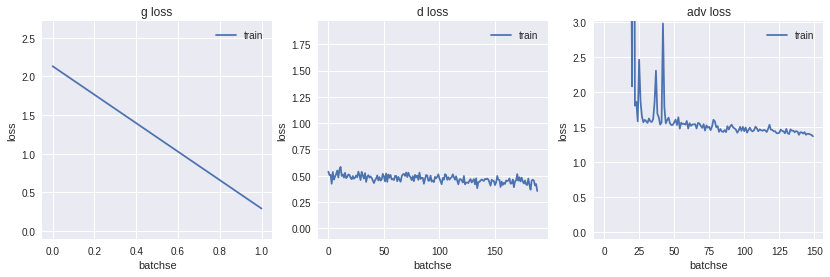

############################## epocs 1
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runni

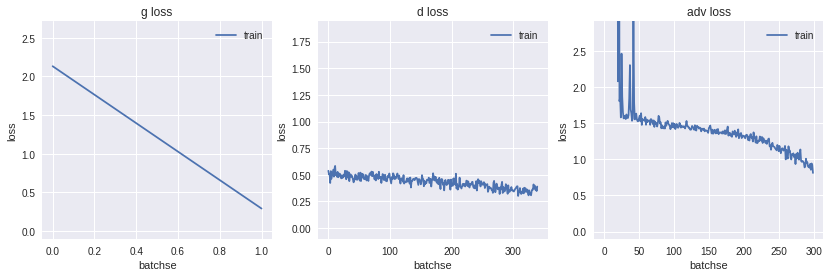

############################## epocs 2
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runni

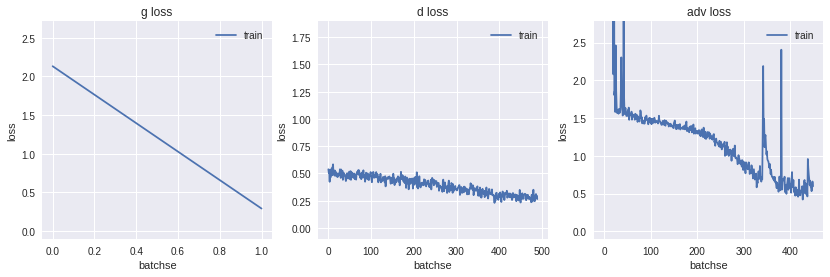

############################## epocs 3
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runni

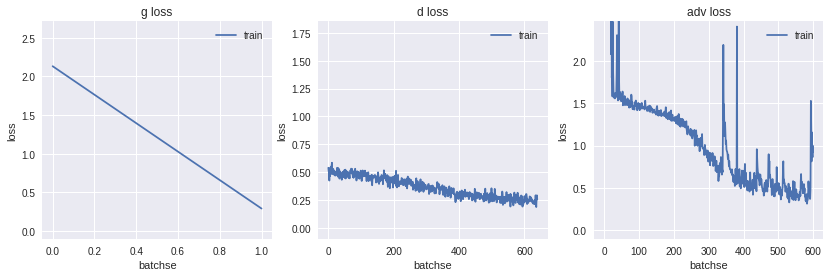

############################## epocs 4
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runni

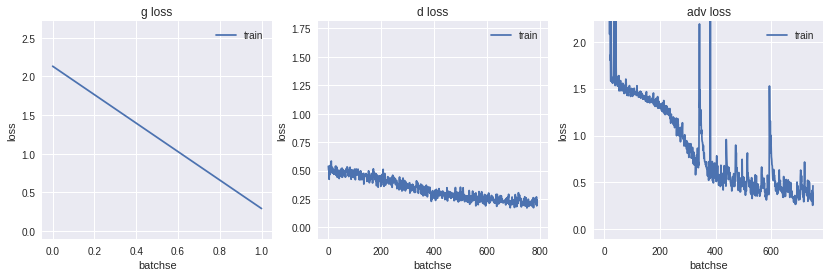

############################## epocs 5
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runni

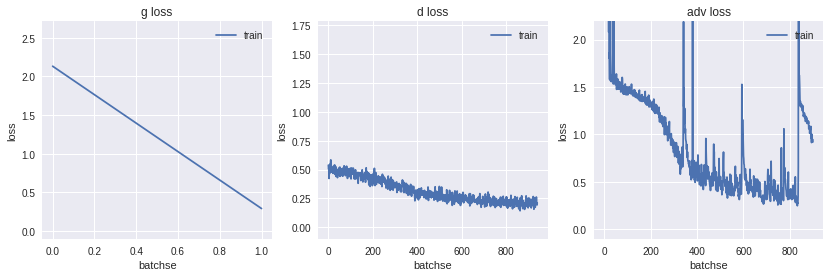

############################## epocs 6
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runni

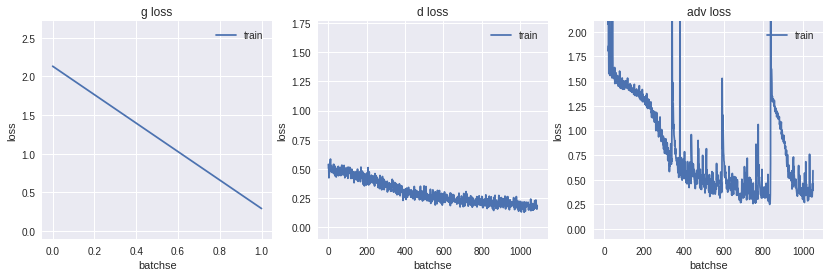

############################## epocs 7
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runni

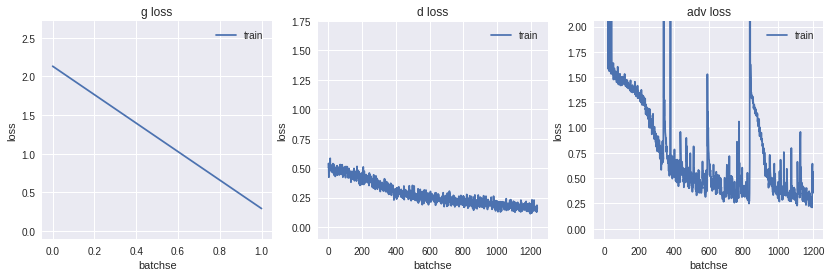

############################## epocs 8
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runni

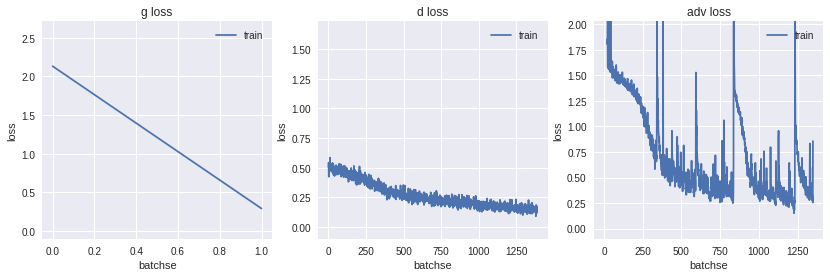

############################## epocs 9
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runni

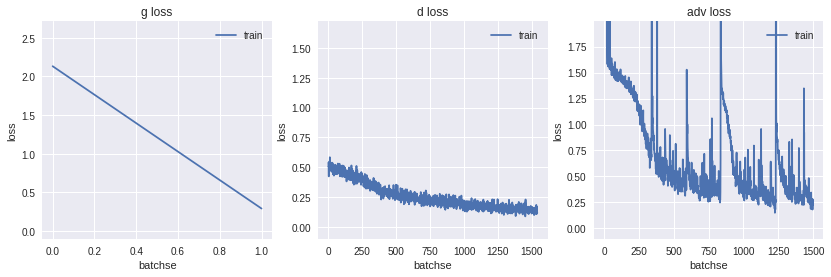

############################## epocs 10
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

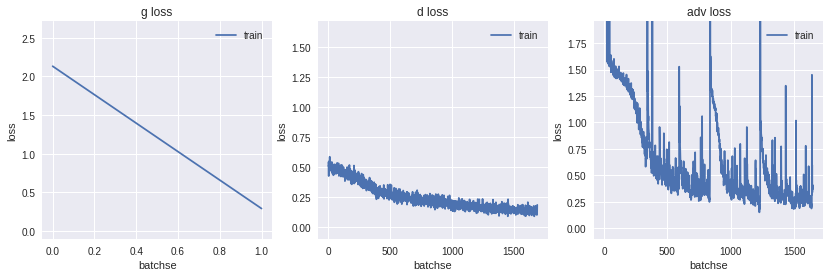

############################## epocs 11
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

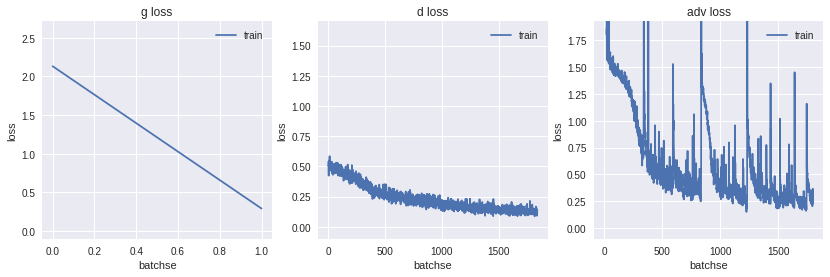

############################## epocs 12
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

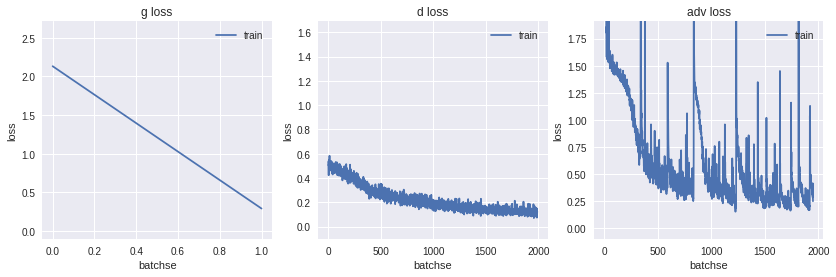

############################## epocs 13
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

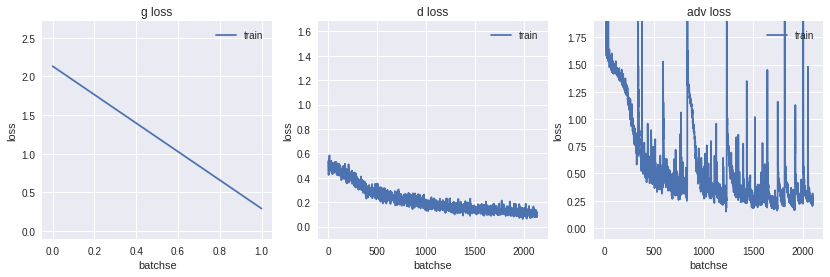

############################## epocs 14
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

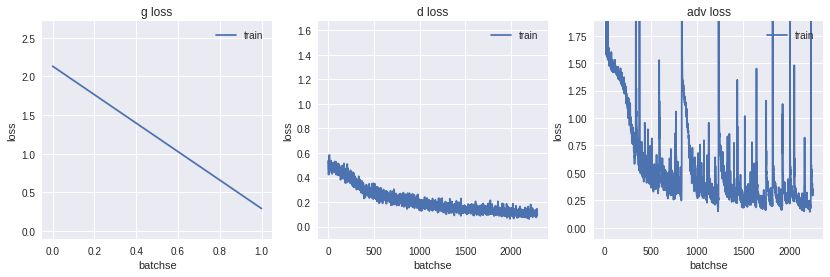

############################## epocs 15
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

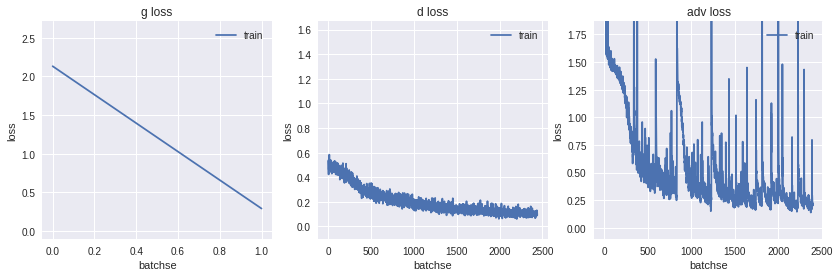

############################## epocs 16
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

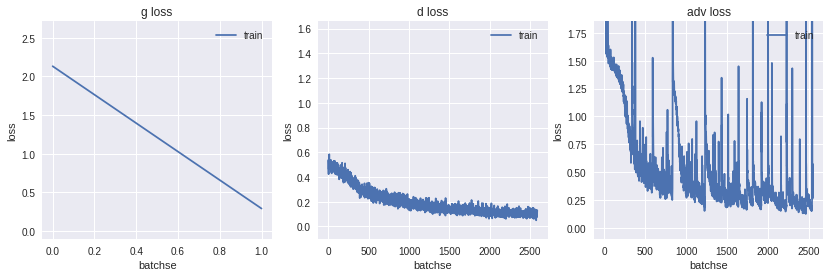

############################## epocs 17
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

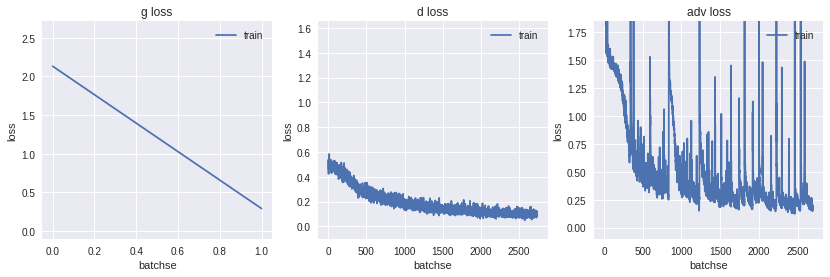

############################## epocs 18
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

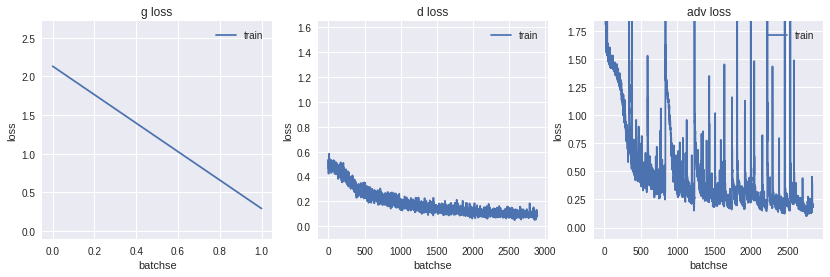

############################## epocs 19
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

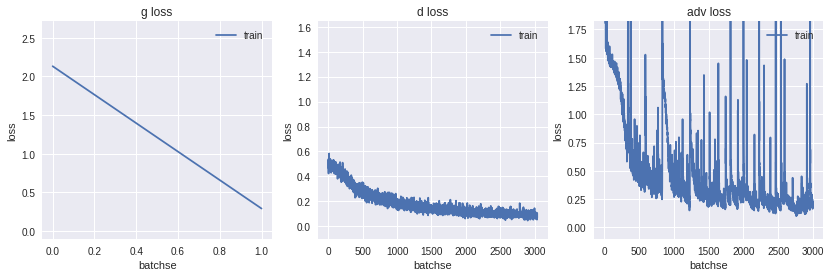

############################## epocs 20
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

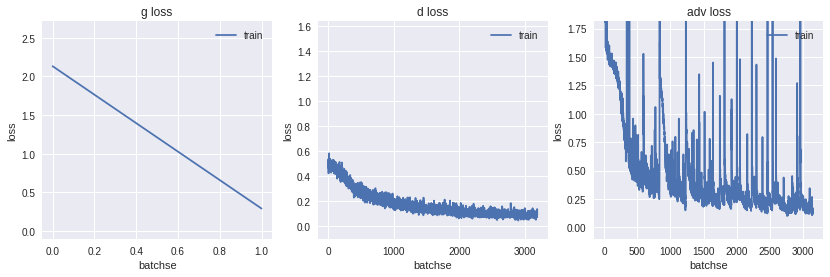

############################## epocs 21
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

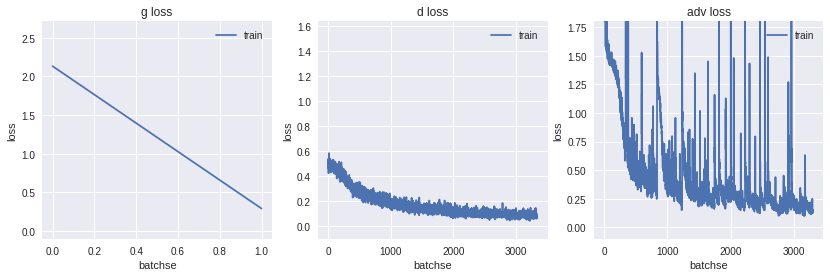

############################## epocs 22
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

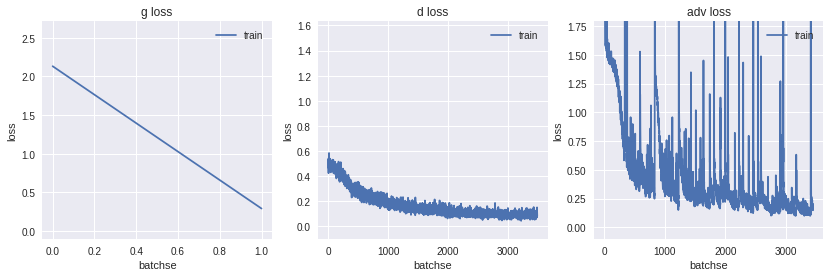

############################## epocs 23
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

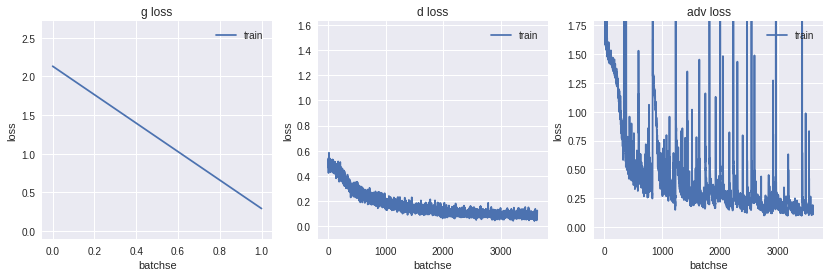

############################## epocs 24
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

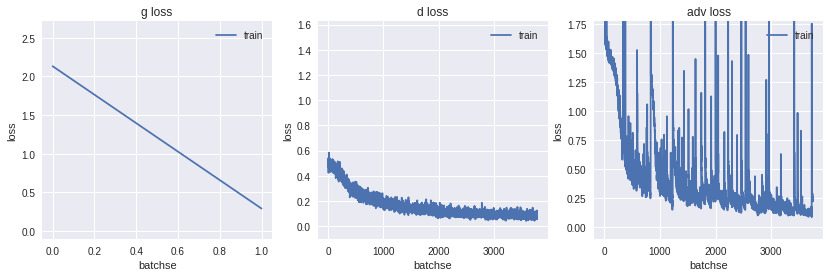

############################## epocs 25
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

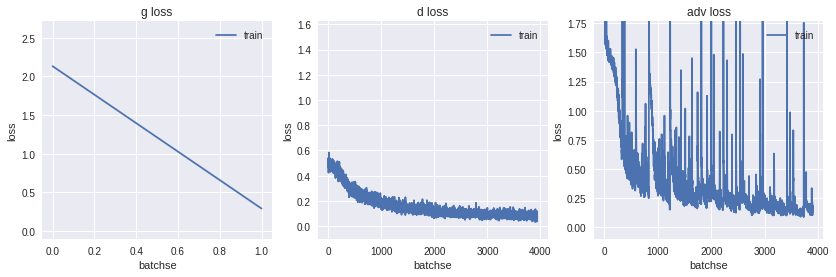

############################## epocs 26
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

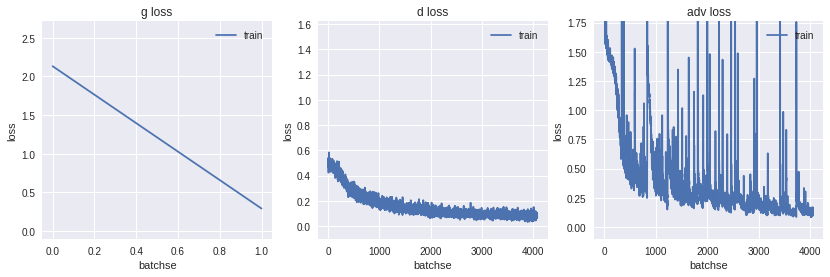

############################## epocs 27
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

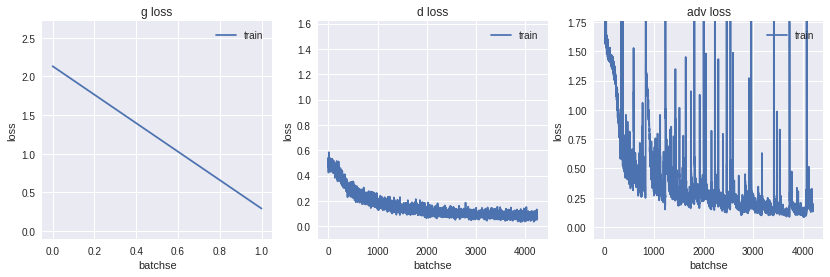

############################## epocs 28
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

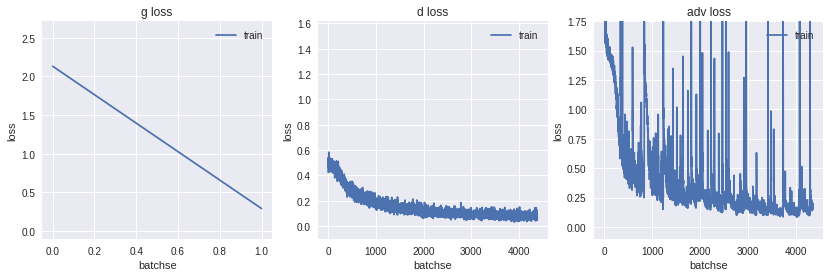

############################## epocs 29
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

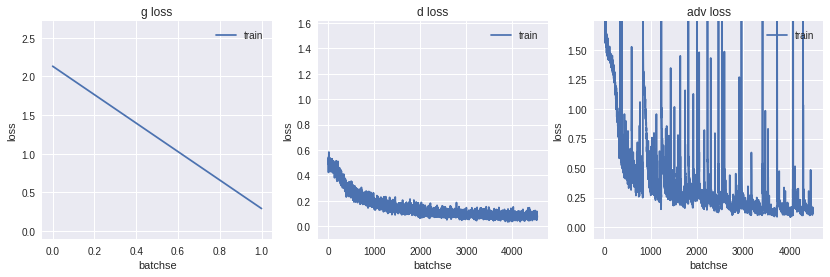

############################## epocs 30
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

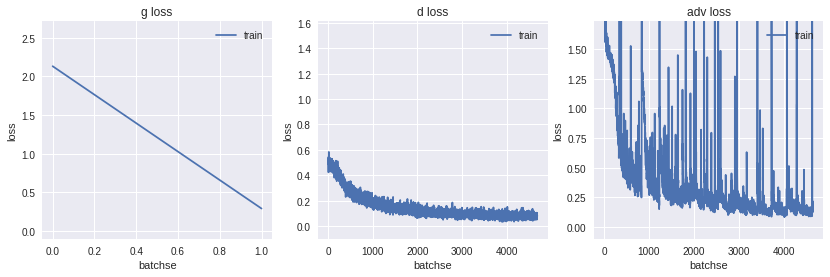

############################## epocs 31
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

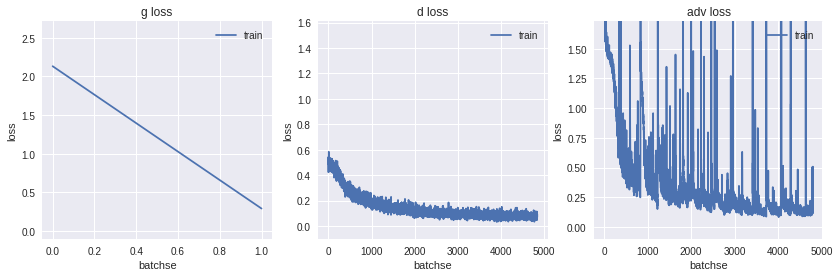

############################## epocs 32
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

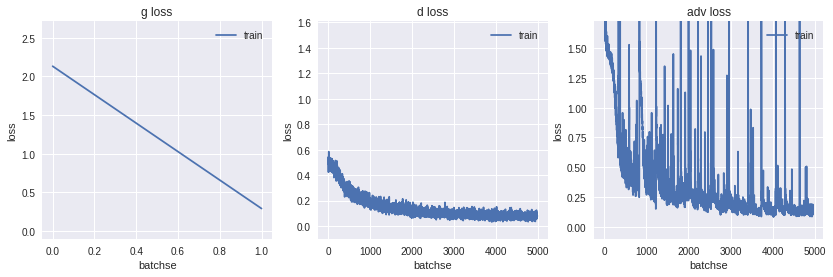

############################## epocs 33
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

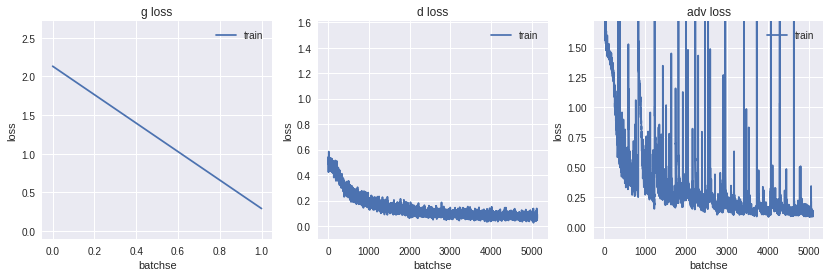

############################## epocs 34
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

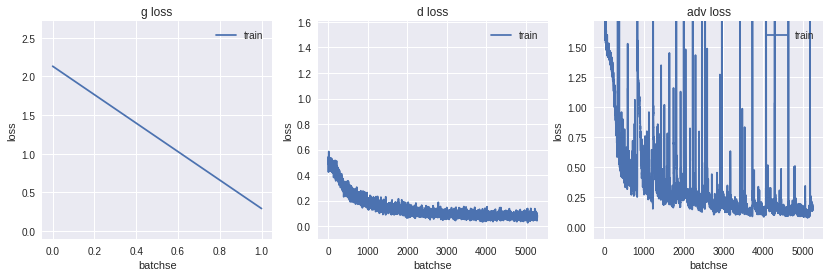

############################## epocs 35
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

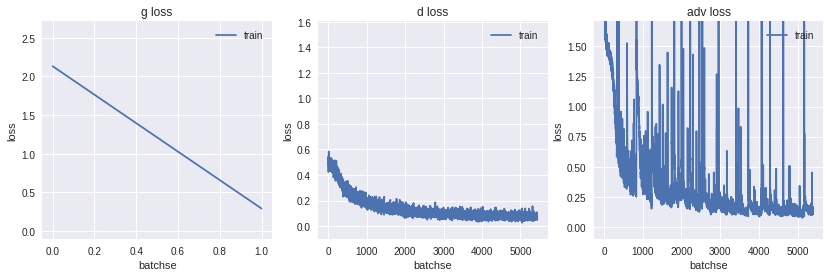

############################## epocs 36
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

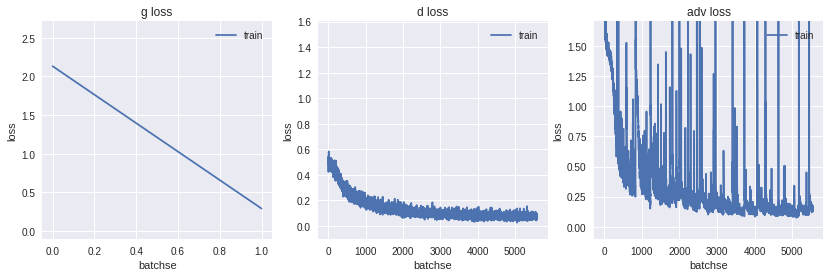

############################## epocs 37
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150
70 expect to wait a minute here on CPU... running few small steps, till 150
80 expect to wait a minute here on CPU... running few small steps, till 150
90 expect to wait a minute here on CPU... running few small steps, till 150
100 expect to wait a minute here on CPU... running few small steps, till 150
110 expect to wait a minute here on CPU... running few small steps, till 150
120 expect to wait a minute here on CPU... runn

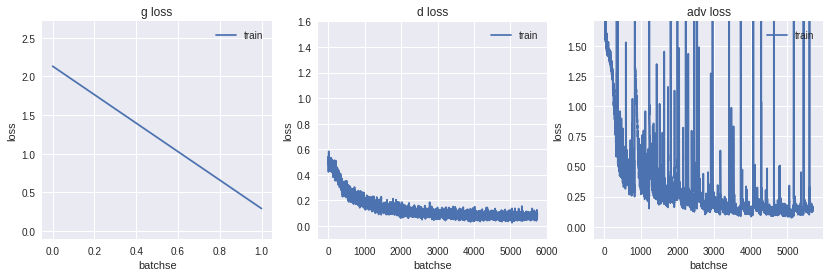

############################## epocs 38
0 expect to wait a minute here on CPU... running few small steps, till 150
10 expect to wait a minute here on CPU... running few small steps, till 150
20 expect to wait a minute here on CPU... running few small steps, till 150
30 expect to wait a minute here on CPU... running few small steps, till 150
40 expect to wait a minute here on CPU... running few small steps, till 150
50 expect to wait a minute here on CPU... running few small steps, till 150
60 expect to wait a minute here on CPU... running few small steps, till 150


KeyboardInterrupt: ignored

In [411]:
print ('epoc contains ',epoc,'batches of', batch_size)
small_steps=5
for e in range(50):
  print ('#'*30,'epocs',e)
  for i in range(int(epoc/small_steps)):
    if i%10 ==0:print (i,'expect to wait a minute here on CPU... running few small steps, till',int(epoc/small_steps))
    
    for j in range(10): #train d until it has a reasnbile value. or enough steps passed
      train_d(d,small_steps)
      l=loss_history_d.losses['loss'][-1:][0]
      if l<0.5:
        break
      
    train_adv(adv_model,small_steps)
  show_sample('train',sample_id=[0],teacher_forcing=True)   #,8000+0
  plt_all()
print ('done')

models      = [encoder_model   , model,    decoder_sampling_model,   d_classifier_model] #rest can be built from them?  
model_names = ['encoder_model', 'model', 'decoder_sampling_model','d_classifier_model' ] #rest can be built from them?  
#Persistency().load_weights_from('models/2018-07-15_10-15-21',models,model_names)
Persistency().save_weights(models,model_names) #not run yet....


############################## verb 0 ##############################
encoder_input  [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
encoder_input  [t_bbe.csv]: At the first God made the heaven and the earth. <s> <s> <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_bbe.csv]: "In the rock of God's preparing the earth and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
decoder TF     [t_ylt.csv]: In the beginning of God's preparing the heavens and the earth -- <s> <s> <s> <s> <s> <s> <s> <s>
############################## verb 1 ##############################
encoder_input  [t_ylt.csv]: "the earth hath <oov> waste and <oov> and darkness `is' on the face of the deep, and the Spirit of
encoder_input  [t_bbe.csv]: And the earth was waste and without form; and it was dark on the face of the <oov> and the
decoder TF     [t_bbe.csv]: "This earth hath <oov> waste and <oov> and darkness `is' on the face of the deep, and the Spirit of
dec

In [163]:
!ls models/2018-07-15_10-15-21

d_classifier_model.h5  decoder_sampling_model.h5  encoder_model.h5  model.h5


# Error analysis

In [2]:
show_sample('train',sample_id=[0,1,2,999],teacher_forcing=False)   #,8000+0
print (' VAL '*10)                          #TEst with FALSE
show_sample('val'  ,sample_id=[0,1,2,999],teacher_forcing=True)   #,8000+0

# VAL SO BAD , TOO MUCH OVERFIT . NOT ENOUGH DATA g0.5/2.5


NameError: ignored

In [287]:



#a= model.predict([x_train[s:e], x_train_d[s:e]])
#for i in range(dataset.MAX_SEQUENCE_LENGTH):
#  best=np.argmax(a[0,i])
#  print (i,best,dataset.index2word[best],a[0,i,best],a[0,i,0])

#NEED TO FIX CODE HERE
from keras.losses import categorical_crossentropy
p=model.predict([x_val,x_val_d])
scores=K.eval(K.sum(categorical_crossentropy(K.constant(p), K.constant(y_val) ),axis=1))
worse_10 = scores.argsort()[::-1][:10]

for i in range(len(worse_10)):
  bad=worse_10[i]
  print (i,'arg',bad,'score',scores[bad],show_sample('val',False,bad))
  


ValueError: ignored

## Error of style disc.

In [211]:
### Error of style discriminator
x,y=next(gen(dataset.result.val,10,'d'))
print ('eval',d.evaluate(x,y))
p=d.predict(x)
for i in range(len(y)):
  print (i,'error',(abs(y[i][0]-p[i][0])),'gold',y[i],p[i],dataset.one_x_as_text(x[i]))





10/10 [==============================] - 0s 2ms/step
eval [0.6257959008216858, 0.8999999761581421]
0 actual 0.38546136 [0. 1.] [0.38546136 0.6145386 ] For I have kept the ways of the Lord; I have not been turned away in sin from my God.
1 actual 0.42803007 [0. 1.] [0.42803007 0.5719699 ] "And while she was still talking with the king, <oov> the prophet came in." <s> <s> <s> <s> <s> <s>
2 actual 0.31531385 [0. 1.] [0.31531385 0.6846862 ] "Then he gave a cry to the servant who was waiting on him and said, Put this woman out, and
3 actual 0.01998341 [1. 0.] [0.9800166  0.01998337] "And all the people come up after him, and the people are <oov> with <oov> and <oov> -- great joy,
4 actual 0.116271734 [0. 1.] [0.11627173 0.8837283 ] "Now the servants of David and <oov> had been out attacking a band of armed men, and they came back
5 actual 0.10636711 [0. 1.] [0.10636711 0.8936329 ] "He made them of liquid metal in the lowland of Jordan, at the way across the river, at <oov> between
6 actual 

# FAQ and wierd exceptions

* If you get exceptions related to cuda-lstm , inside the show_sample, but you actially not using it at all.  You will need to restart the notebook (thinking it's TF issue/bug)

In [53]:
# If d not training (accuracy close to 0.5): check this. from som reason, it is not trainlable
# solution is to recompile, and redefine train_d . TODO: find source of problem
#  Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
#  'Discrepancy between trainable weights and collected trainable'
def print_d_mean():
  print(d.get_layer('d__dense_softmax').get_weights()[0].mean(),'b',d.get_layer('d__dense_softmax').get_weights()[1].mean())
print_d_mean()






-0.0030405987 b 0.0
(len(d.trainable_weights)) 4
encoder_inputs <keras.engine.topology.InputLayer object at 0x7f416565b320> False {'batch_input_shape': (None, None), 'dtype': 'float32', 'sparse': False, 'name': 'encoder_inputs'}
embedding_7 <keras.layers.embeddings.Embedding object at 0x7f416565bc88> False {'name': 'embedding_7', 'trainable': False, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 10000, 'output_dim': 300, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}
bidirectional_7 <keras.layers.wrappers.Bidirectional object at 0x7f41656c9588> False {'name': 'bidirectional_7', 'trainable': False, 'layer': {'class_name': 'CuDNNLSTM', 'config': {'name': 'cu_dnnlstm_13', 'trainable': True, 'return_sequences': False, 'return_state': True, 'go_backwards': False, 'sta

100/100 [==============================] - 3s 30ms/step - loss: 8.1245 - acc: 0.4959 - val_loss: 7.0517 - val_acc: 0.5625
-0.0030405987 b 0.0
g
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50/50 [==============================] - 8s 161ms/step - loss: 4.9978 - val_loss: 5.0033
-0.0030405987 b 0.0
Epoch 1/1
100/100 [==============================] - 4s 37ms/step - loss: 8.0288 - acc: 0.5019 - val_loss: 7.3035 - val_acc: 0.5469
-0.0030405987 b 0.0
(len(d.trainable_weights)) 4


0.0032313007 b 1.3737008e-08
encoder_inputs <keras.engine.topology.InputLayer object at 0x7f40b60c1080> False {'batch_input_shape': (None, None), 'dtype': 'float32', 'sparse': False, 'name': 'encoder_inputs'}
model_106 <keras.engine.training.Model object at 0x7f40b5e6b240> False {'name': 'model_106', 'layers': [{'name': 'encoder_inputs', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, None), 'dtype': 'float32', 'sparse': False, 'name': 'encoder_inputs'}, 'inbound_nodes': []}, {'name': 'embedding_14', 'class_name': 'Embedding', 'config': {'name': 'embedding_14', 'trainable': True, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 10000, 'output_dim': 300, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}, 'inbound_nodes': [[['encoder_inputs', 0, 0, {}

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


150/150 [==============================] - 5s 34ms/step - loss: 8.0003 - acc: 0.5036 - val_loss: 6.5480 - val_acc: 0.5938
0.0032313007 b 1.3737008e-08


False trainable 0 11
True trainable 4 7


2
<keras.engine.topology.InputLayer object at 0x7f40b7b04da0> False
<keras.layers.core.Dense object at 0x7f40b7b04e10> True
<keras.engine.topology.InputLayer object at 0x7f40b7b04da0> False
<keras.layers.core.Dense object at 0x7f40b7b04e10> False


3